## Machine Learning with Spark - Lab

## Introduction

In the previous lecture, you were shown how to manipulate data with Spark DataFrames as well as create machine learning models. In this lab, you're going to practice loading data, manipulating it, and fitting it into the Spark Framework. Afterwords, you're going to make use of different visualizations to see if you can get any insights from the model. Let's get started!

### Objectives

* Create machine learning pipeline with pyspark
* Evaluate a model with pyspark
* Create and interpret visualizations with pyspark

In [1]:
import pyspark

In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession


In [3]:
sc = SparkContext('local[*]')
spark = SparkSession(sc)

In [113]:
spark_df = spark.read.csv('./credit_card_default.csv',header='true',inferSchema='true')

In [114]:
spark_df.dtypes

[('ID', 'int'),
 ('LIMIT_BAL', 'double'),
 ('SEX', 'string'),
 ('EDUCATION', 'string'),
 ('MARRIAGE', 'string'),
 ('AGE', 'int'),
 ('PAY_0', 'int'),
 ('PAY_2', 'int'),
 ('PAY_3', 'int'),
 ('PAY_4', 'int'),
 ('PAY_5', 'int'),
 ('PAY_6', 'int'),
 ('BILL_AMT1', 'double'),
 ('BILL_AMT2', 'double'),
 ('BILL_AMT3', 'double'),
 ('BILL_AMT4', 'double'),
 ('BILL_AMT5', 'double'),
 ('BILL_AMT6', 'double'),
 ('PAY_AMT1', 'double'),
 ('PAY_AMT2', 'double'),
 ('PAY_AMT3', 'double'),
 ('PAY_AMT4', 'double'),
 ('PAY_AMT5', 'double'),
 ('PAY_AMT6', 'double'),
 ('default', 'int')]

In [115]:
from pyspark.sql import functions

In [116]:
for col in spark_df.columns:
    print('column',col,spark_df.filter(spark_df[col].isNull()).count())

column ID 0
column LIMIT_BAL 0
column SEX 0
column EDUCATION 0
column MARRIAGE 0
column AGE 0
column PAY_0 0
column PAY_2 0
column PAY_3 0
column PAY_4 0
column PAY_5 0
column PAY_6 0
column BILL_AMT1 0
column BILL_AMT2 0
column BILL_AMT3 0
column BILL_AMT4 0
column BILL_AMT5 0
column BILL_AMT6 0
column PAY_AMT1 0
column PAY_AMT2 0
column PAY_AMT3 0
column PAY_AMT4 0
column PAY_AMT5 0
column PAY_AMT6 0
column default 0


In [119]:
for column , data_type in spark_df.dtypes:
    if data_type == 'string':
        print('Feature ',column,' has: ', spark_df.select(column).distinct().collect())

Feature  SEX  has:  [Row(SEX='Female'), Row(SEX='Male')]
Feature  EDUCATION  has:  [Row(EDUCATION='High School'), Row(EDUCATION='0'), Row(EDUCATION='5'), Row(EDUCATION='6'), Row(EDUCATION='Other'), Row(EDUCATION='Graduate'), Row(EDUCATION='College')]
Feature  MARRIAGE  has:  [Row(MARRIAGE='0'), Row(MARRIAGE='Other'), Row(MARRIAGE='Married'), Row(MARRIAGE='Single')]


Interesting... it looks like we have some extraneous values in each of our categories. Let's look at some visualizations of each of these to determine just how many of them there are. Create histograms of the variables EDUCATION and MARRIAGE to see how many of the undefined values there are. After doing so, come up with a strategy for accounting for the extra value.

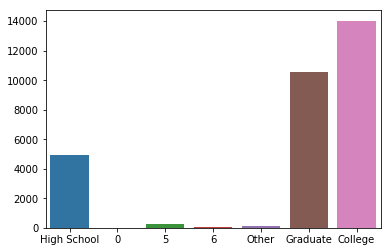

In [125]:
education_cats = spark_df.groupBy('EDUCATION').count().collect()
sns.barplot(x=bar_plot_values(0,education_cats),y=bar_plot_values(1,education_cats))

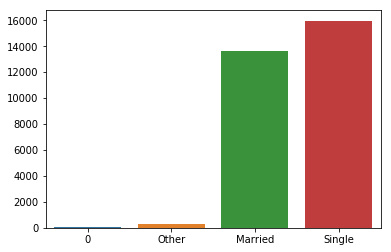

In [145]:
marriage_cats =  spark_df.groupby('MARRIAGE').count().collect()
sns.barplot(x=bar_plot_values(0, marriage_cats), y=bar_plot_values(1, marriage_cats))

It looks like there are barely any of the categories of 0 and 5 categories. We can go ahead and throw them into the "Other" category since it's already operating as a catchall here. Similarly, the category "0" looks small, so let's throw it in with the "Other" values.

In [137]:
x = spark_df.select('EDUCATION') == '0'
x

False

In [146]:
from pyspark.sql.functions import when

# conditional = spark_df['EDUCATION'] == '0' |  spark_df['EDUCATION'] == '5' | spark_df['EDUCATION'] == '6'
spark_df_2 = spark_df.withColumn("EDUCATION",
                    when(spark_df.EDUCATION == '0','Other')\
                    .when(spark_df.EDUCATION == '5','Other')\
                    .when(spark_df.EDUCATION == '6','Other')\
                    .otherwise(spark_df['EDUCATION']))

spark_df_done = spark_df_2.withColumn("MARRIAGE",
                                   when(spark_df.MARRIAGE == '0','Other')\
                                   .otherwise(spark_df['MARRIAGE']))

In [147]:
for column , data_type in spark_df_done.dtypes:
    if data_type == 'string':
        print('Feature ',column,' has: ', spark_df_done.select(column).distinct().collect())

Feature  SEX  has:  [Row(SEX='Female'), Row(SEX='Male')]
Feature  EDUCATION  has:  [Row(EDUCATION='High School'), Row(EDUCATION='Other'), Row(EDUCATION='Graduate'), Row(EDUCATION='College')]
Feature  MARRIAGE  has:  [Row(MARRIAGE='Other'), Row(MARRIAGE='Married'), Row(MARRIAGE='Single')]


Much better. Now, let's do a little more EDA before diving into the machine learning aspect of this project.

## EDA

Let's first look at the overall distribution of class imbalance to determine if there is a need for each one of the different things here.

In [22]:
number_of_defaults = spark_df.groupBy('default').count().collect()


In [66]:
default = [x[0] for x in number_of_defaults]
num_defaults = [x[1] for x in number_of_defaults]

Text(0,0.5,'Number of Defaults')

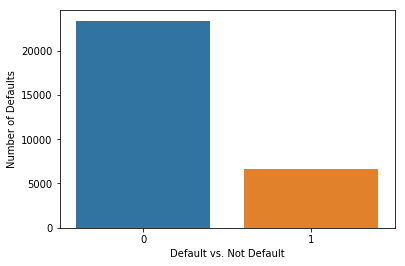

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.barplot(default,num_defaults,tick_label=['No Default','Default'])
# ax.xlabel('Default')
# ax.ylabel('Number of Defaults')
ax.set_xlabel('Default vs. Not Default')
ax.set_ylabel('Number of Defaults')

In [55]:
## a reasonable class balance, no real issues with class imbalances

In [77]:
results = spark_df.groupBy(['SEX','default']).count().collect()

In [78]:
results

[Row(SEX=1, default=0, count=9015),
 Row(SEX=1, default=1, count=2873),
 Row(SEX=2, default=1, count=3762),
 Row(SEX=2, default=0, count=14349)]

In [68]:
def bar_plot_values(idx,group):
    return [x[idx] for x in group]

In [64]:
defaulted = results[:2]
not_defaulted = results[2:]


In [73]:
bar_plot_values(1,defaulted)

[1, 1]

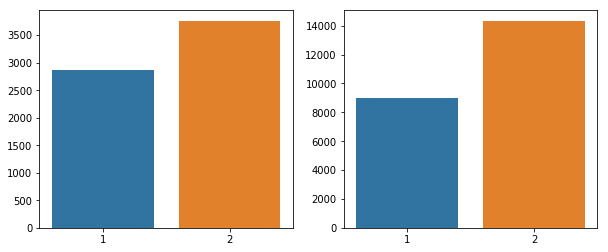

In [76]:
f, axes = plt.subplots(1,2)
f.set_figwidth(10)
sns.barplot(x= bar_plot_values(1,defaulted),y=bar_plot_values(2,defaulted),ax=axes[0])
sns.barplot(x= bar_plot_values(1,not_defaulted),y=bar_plot_values(2,not_defaulted),ax=axes[1])



In [ ]:
results = spark_df.groupBy(['SEX','default']).count().collect()

In [13]:
import seaborn as sns
sns.categorical.boxplot()

## Onto the Machine Learning!

In [150]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StringIndexerModel

In [160]:
l = [3,4,5,]
t = [4,5,3]
c = [6,2,8]
l += [t,c]

l

[3, 4, 5, [4, 5, 3], [6, 2, 8]]

In [164]:
stages = []
indexers = []

for col in ['EDUCATION','SEX','MARRIAGE']:
    indexers.append(StringIndexer(inputCol =col,outputCol=col+'_',handleInvalid='keep'))
    
input_columns = [indexer.getOutputCol() for indexer in indexers]

one_hot_encoder = OneHotEncoderEstimator(inputCols=input_columns,outputCols=[col + 'ohe' for col in input_columns])

features = ['LIMIT_BAL','AGE','PAY_0','PAY_2','PAY_3',
            'PAY_4','PAY_5','PAY_6', 'BILL_AMT1','BILL_AMT2',
            'BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']

features.extend(one_hot_encoder.getOutputCols())

vector_assember = VectorAssembler(inputCols= features , outputCol='features')

stages.extend(indexers)
stages.extend([one_hot_encoder,vector_assember])
print(stages)

[StringIndexer_4a1ebab6194451f0ef0e, StringIndexer_441fb14e4ffbca71828c, StringIndexer_4814b38309b2c37240d2, OneHotEncoderEstimator_422a926e5bfe35ae5a07, VectorAssembler_47d0a99f6577b8dcce9a]


Now let's create all the stages here to make 

In [156]:
x.getOutputCol()

'EDUCATION_'

In [84]:
from pyspark.ml.feature import OneHotEncoderEstimator, VectorAssembler

ohe = OneHotEncoderEstimator(inputCols=['SEX','EDUCATION','MARRIAGE'],outputCols=['SEX_c','EDUCATION_c','MARRIAGE_c'])

In [85]:
ohe.fit(spark_df)

OneHotEncoderEstimator_4cdd8e04d5de9b43dc2e

In [87]:
import pandas as pd

In [97]:
df = pd.read_csv('./credit_default.csv')

In [98]:
df.loc[df['SEX'] == 2 ,'SEX'] = 'Female'
df.loc[df['SEX'] == 1 ,'SEX'] = 'Male'

In [99]:
df.loc[df['EDUCATION'] == 1,'EDUCATION'] = 'Graduate'
df.loc[df['EDUCATION'] == 2,'EDUCATION'] = 'College'
df.loc[df['EDUCATION'] == 3,'EDUCATION'] = 'High School'
df.loc[df['EDUCATION'] == 4,'EDUCATION'] = 'Other'

In [101]:
df.loc[df['MARRIAGE'] == 1,'MARRIAGE'] = 'Married'
df.loc[df['MARRIAGE'] == 2,'MARRIAGE'] = 'Single'
df.loc[df['MARRIAGE'] == 3,'MARRIAGE'] = 'Other'



In [112]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,2,120000.0,Female,College,Single,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
1,3,90000.0,Female,College,Single,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
2,4,50000.0,Female,College,Married,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
3,5,50000.0,Male,College,Married,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
4,6,50000.0,Male,Graduate,Single,37,0,0,0,0,...,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0


In [110]:
df.to_csv('credit_card_default.csv')

In [111]:
pd.read_csv('./credit_card_default.csv')

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,2,120000.0,Female,College,Single,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
1,3,90000.0,Female,College,Single,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
2,4,50000.0,Female,College,Married,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
3,5,50000.0,Male,College,Married,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
4,6,50000.0,Male,Graduate,Single,37,0,0,0,0,...,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0
5,7,500000.0,Male,Graduate,Single,29,0,0,0,0,...,542653.0,483003.0,473944.0,55000.0,40000.0,38000.0,20239.0,13750.0,13770.0,0
6,8,100000.0,Female,College,Single,23,0,-1,-1,0,...,221.0,-159.0,567.0,380.0,601.0,0.0,581.0,1687.0,1542.0,0
7,9,140000.0,Female,High School,Married,28,0,0,2,0,...,12211.0,11793.0,3719.0,3329.0,0.0,432.0,1000.0,1000.0,1000.0,0
8,10,20000.0,Male,High School,Single,35,-2,-2,-2,-2,...,0.0,13007.0,13912.0,0.0,0.0,0.0,13007.0,1122.0,0.0,0
9,11,200000.0,Female,High School,Single,34,0,0,2,0,...,2513.0,1828.0,3731.0,2306.0,12.0,50.0,300.0,3738.0,66.0,0
